In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from src.mssm import utils,models

In [2]:
# Initializer function to get starting estimates
def prop_states_init(n_j,end_point,sd=5):

    # Start with equally spaced states
    start = np.array(range(0,
                                end_point,
                                round(end_point/n_j)))[1:(n_j - 1)]

    start = np.insert(start,0,0)
    start = np.insert(start,len(start),end_point)


    # Then make large random steps away from equally spaced states.
    prop_dur_state, prop_state = utils.prop_norm(end_point,start,sd=sd)

    rejection = utils.pre_ll_sms_dc_gamm(n_j,end_point,prop_dur_state,prop_state)

    while rejection:
        prop_dur_state, prop_state = utils.prop_norm(end_point,start,sd=sd)
        rejection = utils.pre_ll_sms_dc_gamm(n_j,end_point,prop_dur_state,prop_state)

    return prop_dur_state, prop_state

## Data structure

### How to prepare for your analysis:

We have data from multiple conditions. Thus a good starting point is to fit the first model discussed here (anything before: **Increasing complexity**) to separate data sets - one for each condition. Start maybe with the number of stages suggested from previous experiments (since model comparisons are not working yet). That way you don't have to change anything (except for the ``n_j`` parameter) about the model. You can use the ``utils.create_event_matrix_time`` function and rely on the penalty code I wrote.

You can even set ``cov = [None for s in range(n_s)]``, because we don't have random effects in the simplest model.

Then you need to only provide ``y_mat``, ``time``, and ``trial_end``. The last one should simply be the **sample** (or the closest one) matching the response time point. ``y_mat`` needs to be a ``list`` of ``np.arrays`` - one array per series. ``time`` needs to be of the same dimension and type structure (i.e., a list of arrays) as ``y_mat`` and should simply contain the time-series matching the observation values included in ``y_mat``.

##### Example:

If your trials are down-sampled to 50 Hz (20 ms per sample) and you have a trial ``s`` that ends after 800 ms, then ``trial_end[s]=40``. Let's say you include data from stimulus onset to 1.5 seconds after response onset, then both ``y_mat[s]`` and ``time[s]`` should have a length of 115 (115 samples times 20 ms = 800 ms until response + 1500 ms). ``y_mat[s]`` should contain the pupil size at each of those 115 samples while ``time[s]`` should contain the **time-points** corresponding to those samples. That is ``time[s][0:5] = np.array([0, 20, 40, 60, 80])``.

In [3]:
# Import some simulated data
n_s = 20
y_mat = list(np.load("./data/dcGAMM/no_rand/series.npy"))[0:n_s]
time = list(np.load("./data/dcGAMM/no_rand/time_series.npy"))[0:n_s]
trial_end = list(np.load("./data/dcGAMM/no_rand/trial_ends.npy"))[0:n_s]
cov = list(np.load("./data/dcGAMM/no_rand/covariates.npy"))[0:n_s]
# cov = [None for s in range(n_s)] # Works for first model as well!

In [4]:
# Since ever trial can be of different length we work with regular lists.
# Every element in y_mat should represent a pupil dilation time course in our
# case. Each time-course should be stored as np.array(). Time courses can contain
# missing values, which need to be marked as np.nan
y_mat[0][0:10]

array([        nan,         nan,         nan,         nan,         nan,
       -1.01649463,  0.55915381,  1.21507684, -0.59998462, -3.55308197])

In [5]:
# time should match y_mat and should not contain any missing values
time[0][0:10]

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.])

In [6]:
# trial-end should contain for every time series the end **sample**,
# indicating in our case when the trial was over. Note, this is not
# necessarily reflecting the length of the corresponding series
print(trial_end[0],len(time[0]))

49 151


In [7]:
# cov contains any covariates. So len(cov) == len(time) == len(y_mat).
# Importantly, cov[j].shape[0] == len(time[j]) == len(y_mat[j]), but cov[j].shape[1] can be anything
# as long as it's consistent per j. In words: for every time point we can store one or more (shape[1])
# covariates. Here we simply store 1 covariate - the series identifier.
# Note, this is a bug here - cov[j] should be an np.array, not a list. But it still works in this case...
print(cov[0][0:10])

[0 0 0 0 0 0 0 0 0 0]


## Model setup

1) Define initial parameters
    1.1) Penalties
2) Define the model
    2.1) Model matrix function
3) Run the model
4) Visualize

In [8]:
# Hyper parameters
n_j = 4 # Number of events - trial onset and end always elicit a response!
n_k = 15 # Number of basis functions
n_chains = 5 # Number of chains estimated

### Initial parameters

scalesc = np.array([10 for _ in range(n_j-1)]) # Sojourn time distribution guesses
pic = None # Initial state is always the first one in left-right hsmm
Tc = None # Transition probabilities are also fixed.
sigmasc = 10 # Initial sigma estimate (standard deviation of residuals)

# Generate initial state estimates
c_state_est = [[[]] for _ in range(n_chains)]
c_state_dur_est = [[[]] for _ in range(n_chains)]
for nc in range(n_chains):

    for s in range(n_s):
        new_state_durs, new_states = prop_states_init(n_j,trial_end[s],sd=5)
        c_state_est[nc][0].append(new_states)
        c_state_dur_est[nc][0].append(new_state_durs)


### Penalties

In [9]:
# As shown in tutorial 1, we penalize the functions we estimate to make sure we don't overfit.
# For our simplest model we define penalties on n_j functions - one for every event we estimate.
# The penalties match in dimension the smooths (n_k). We also set the start_index since we have
# one unpenalized term in our model matrix - the first intercept.

lTerms = [utils.LambdaTerm(penalties = [utils.diff_pen(n_k,3,identifiable=False)[0] for _ in range(n_j)],start_index=1)]

## Defining the model

In [10]:
# The mssm.models file contains a base class and two templates. For us the sMsDCGAMM class
# is the one that matters. Apart from the parameters we defined earlier we need to provide
# a likelihood function and a prior likelihood function - defining any prior knowledge we
# have about the state estimates we want to recover.

m = models.sMsDCGAMM(n_j,y_mat,time,trial_end,
                         utils.ll_sms_dc_gamm,
                         utils.pre_ll_sms_dc_gamm,
                         cov,
                         cpus=6)

# Our estimation algorithm is stochastic so we need a convergence schedule.
# For practical purposes only the ``iter`` argument should be changed, b is
# likely at a good value for our purposes.
m.set_temp(utils.anneal_temps,iter=100,b=0.005)
m.set_penalties(lTerms)

### Model matrix function

In [11]:
# Now the main thing that needs to be done by the user is the definition of the model matrix.
# Here we assume that there are n_j events and each of those elicits a response. We also
# want to add an intercept term. A function that achieves this looks as follows:

def create_event_matrix_time(time,cov,state_est,
                             identifiable = False, # You can generally set this to False for our purposes.
                             drop_outer_k=False, # Same
                             convolve=True, # This one is important, since it makes sure our functions are shifted to event onset!
                             min_c=0, # Minimum of covariate of interest - for us time
                             max_c=2500, # Maximum of covariate of interest - useful together with convolve to restrict possible function space
                             nk=10, # Number of bases per function to be estimated
                             deg=2): # Degree of function

  # Create intercept for series
  inter = utils.constant_basis(None,time,state_est,convolve=False,max_c=None)

  # Create matrix for first onset because depending on the
  # basis there might be different dimensions!
  matrix_first = utils.B_spline_basis(0,time,state_est, identifiable, drop_outer_k, convolve, min_c, max_c, nk, deg)

  rowsMat, colsMat = matrix_first.shape

  # Now that dimensions are known expand for number of
  # event locations.
  event_matrix = np.zeros((rowsMat,colsMat * len(state_est)))
  event_matrix[:,0:colsMat] = matrix_first

  # And fill with the remaining design matrix blocks.
  # This results in a block-shifted matrix - see visualization section below for more explanation!
  cIndex = colsMat
  for ci in range(1,len(state_est)):
    event_matrix[:,cIndex:cIndex+colsMat] = utils.B_spline_basis(ci,time,state_est, identifiable, drop_outer_k, convolve, min_c, max_c, nk, deg)
    cIndex += colsMat

  return np.concatenate((inter,event_matrix),axis=1)

In [12]:
# Multi-processing does not like functions defined in notebooks.. so we import this function.
m.set_mat_fun(utils.create_event_matrix_time,identifiable=False,drop_outer_k=False, convolve=True, max_c=2500, nk=n_k, deg=2)

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


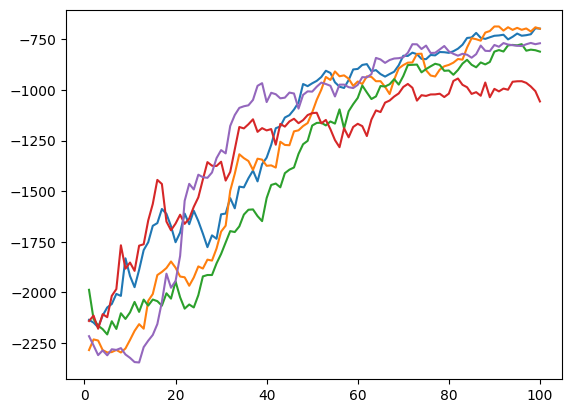

In [13]:
m.fit([[pic] for _ in range(n_chains)],
      [[Tc] for _ in range(n_chains)],
      [[np.ndarray.flatten(np.array([scp.stats.norm.rvs(size=1 + n_j*n_k)]))] for _ in range(n_chains)],
      [[sigmasc] for _ in range(n_chains)],
      [[scalesc] for _ in range(n_chains)],
      c_state_dur_est,
      c_state_est,
      n_chains=n_chains)

## Visualization

In [14]:
# We can get the best parameters with this function!
best_chain,state_est, coef_est,_,_,_,_ = m.get_last_pars_max()

In [15]:
# coef_est contains for every column in the model matrix the associated weight
np.round(coef_est)

array([ 1.,  1., -1., -0.,  1., 13., 23., 17.,  6., -3., -3.,  0.,  2.,
        2.,  1.,  1.,  1., -0.,  0., -0., -4., -2.,  2., 12., 13.,  9.,
        4.,  2.,  1.,  1.,  1.,  1., -1.,  6., 33., 53., 43., 17., -0.,
       -7., -7., -5., -3., -3., -0., -2.,  2., -0., -7., -8., 19., 48.,
       48., 33., 17.,  8.,  3.,  1., -1.,  1.,  0.])

In [16]:
# We can simply estimate the model matrix for one series using the same function
# we passed to the model earlier.
mat_s = utils.create_event_matrix_time(time[0],
                                       [0 for _ in range(len(time[0]))],
                                       state_est[0],
                                       identifiable=False,
                                       drop_outer_k=False,
                                       convolve=True,
                                       max_c=2500,
                                       nk=n_k,
                                       deg=2)

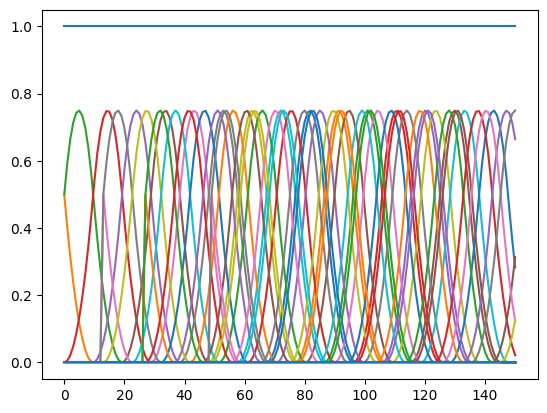

In [17]:
# Let's take a look at the columns!
for ci in range(mat_s.shape[1]):
    plt.plot(mat_s[:,ci])
plt.show()

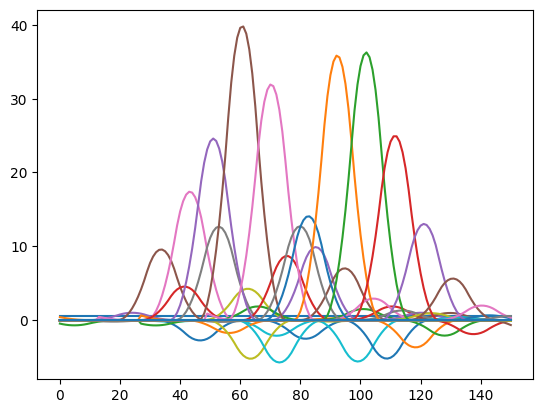

In [18]:
# Let's take a look at the columns - this time weighted by coefficients!
for ci in range(mat_s.shape[1]):
    plt.plot(mat_s[:,ci] * coef_est[ci])
plt.show()

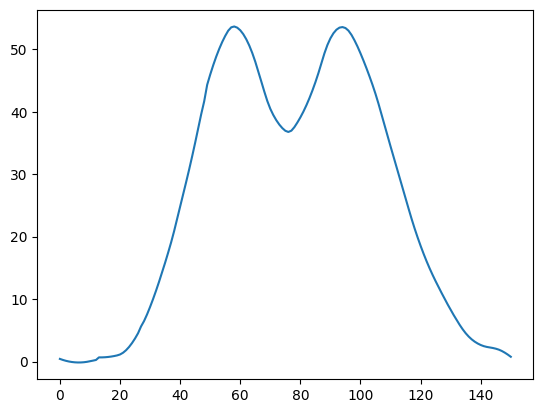

In [19]:
# The sum of all those weighted columns should result in our pupil dilation time-course for that series!
plt.plot(mat_s @ coef_est)
plt.show()

[ 0 13 27 49]


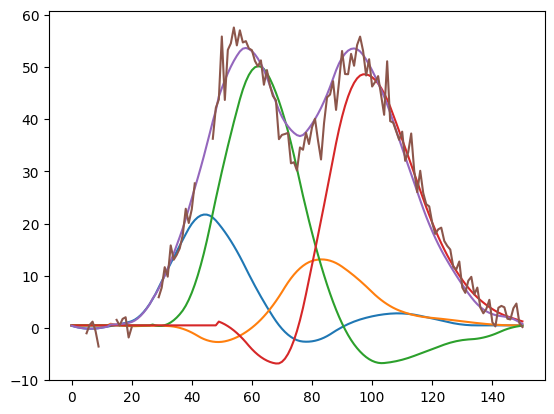

[ 0  2 10 22]


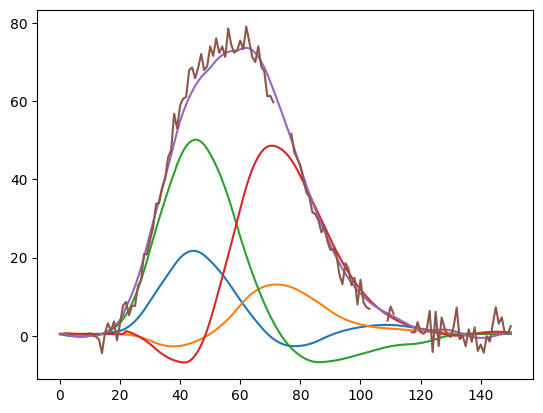

[ 0  2 19 65]


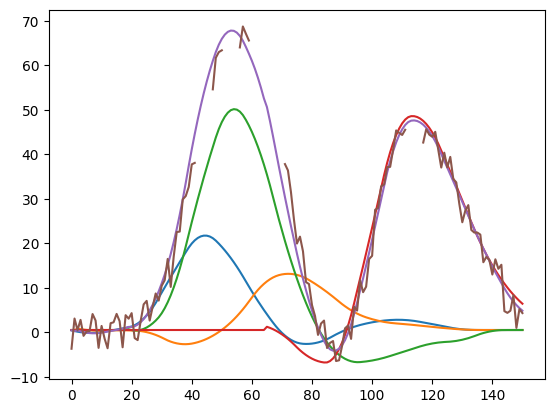

[ 0  7 11 54]


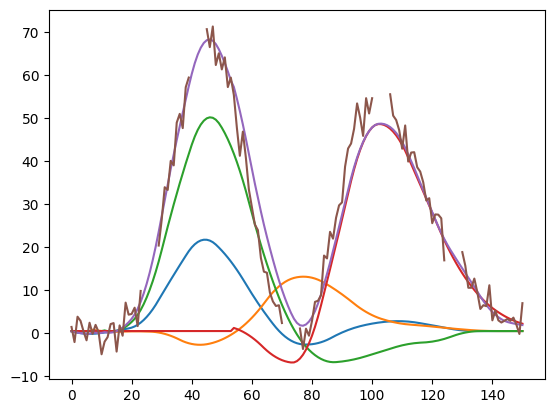

[ 0 31 39 59]


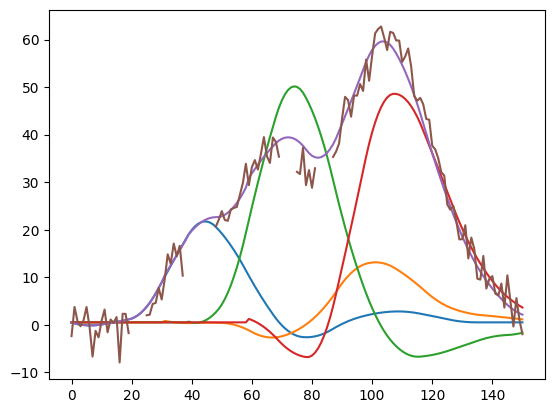

In [20]:
# We can also visualize this per event - since multiple weighted columns together reflect the response
# elicited by an individual event - and for multiple subjects!
# This can also help to identify whether the model is specified correctly and whether it converged sufficiently.
for s in range(5):
    pulse_loc_s = state_est[s]
    print(pulse_loc_s)
    mat_s = utils.create_event_matrix_time(time[s],[s for _ in range(len(time[s]))],pulse_loc_s,identifiable=False,drop_outer_k=False, convolve=True, max_c=2500, nk=n_k, deg=2)
    y_s = np.ndarray.flatten(y_mat[s])
    ii = 1
    iii = 0
    for i in range(n_k,n_k*len(pulse_loc_s),n_k):
        plt.plot(mat_s[:,ii:i] @ coef_est[ii:i] + coef_est[0])
        iii += 1
        ii += n_k
    plt.plot(mat_s[:,ii:ii+n_k] @ coef_est[ii:ii+n_k] + coef_est[0])
    plt.plot(mat_s @ coef_est)
    plt.plot(y_s)
    plt.show()

## Increasing complexity

In [21]:
# The model we have dealt with so far, is quite simple - let's make it a bit more complicated by adding random
# intercepts to our matrix building function.
def create_event_matrix_time2(time,cov,state_est,
                             identifiable = False, # You can generally set this to False for our purposes.
                             drop_outer_k=False, # Same
                             convolve=True, # This one is important, since it makes sure our functions are shifted to event onset!
                             min_c=0, # Minimum of covariate of interest - for us time
                             max_c=2500, # Maximum of covariate of interest - useful together with convolve to restrict possible function space
                             nk=10, # Number of bases per function to be estimated
                             deg=2, # Degree of function
                             n_s=20): # Number of series - here we estimate a random intercept for every series!

  # Create intercept for series
  inter = utils.constant_basis(None,time,state_est,convolve=False,max_c=None)

  # Create matrix for first onset because depending on the
  # basis there might be different dimensions!
  matrix_first = utils.B_spline_basis(0,time,state_est, identifiable, drop_outer_k, convolve, min_c, max_c, nk, deg)

  rowsMat, colsMat = matrix_first.shape

  # Now that dimensions are known expand for number of
  # event locations.
  event_matrix = np.zeros((rowsMat,colsMat * len(state_est)))
  event_matrix[:,0:colsMat] = matrix_first

  # And fill with the remaining design matrix blocks.
  # This results in a block-shifted matrix - see below for more explanation!
  cIndex = colsMat
  for ci in range(1,len(state_est)):
    event_matrix[:,cIndex:cIndex+colsMat] = utils.B_spline_basis(ci,time,state_est, identifiable, drop_outer_k, convolve, min_c, max_c, nk, deg)
    cIndex += colsMat

  # Random intercepts for every covariate level of series
  s = list(set(cov))[0]
  rand_int_s = np.zeros((rowsMat,n_s))
  rand_int_s[:,s] = 1 # Only column corresponding to this series differs!

  return np.concatenate((inter,event_matrix,rand_int_s),axis=1)

In [22]:
# Now let's setup the new model
lTerms2 = [utils.LambdaTerm(penalties = [utils.diff_pen(n_k,3,identifiable=False)[0] for _ in range(n_j)],start_index=1),
          utils.LambdaTerm(penalties = [utils.id_dist_pen(n_s,lambda x: 1)])] # We have added a penalty for the random intercept - the type is important here!

In [23]:
m2 = models.sMsDCGAMM(n_j,y_mat,time,trial_end,
                         utils.ll_sms_dc_gamm,
                         utils.pre_ll_sms_dc_gamm,
                         cov,
                         cpus=6)

m2.set_temp(utils.anneal_temps,100,b=0.005)
m2.set_penalties(lTerms2)

In [24]:
# We again set our matrix function
m2.set_mat_fun(utils.create_event_matrix_time2,identifiable=False,drop_outer_k=False, convolve=True, max_c=2500, nk=n_k, deg=2,n_s=n_s)

100%|██████████| 100/100 [02:49<00:00,  1.70s/it]


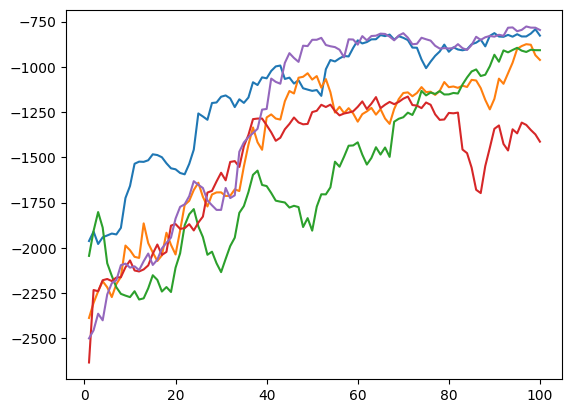

In [25]:
# And now fit the model
m2.fit([[pic] for _ in range(n_chains)],
      [[Tc] for _ in range(n_chains)],
      [[np.ndarray.flatten(np.array([scp.stats.norm.rvs(size=1 + n_j*n_k + n_s)]))] for _ in range(n_chains)], # Note - more coefficients!!
      [[sigmasc] for _ in range(n_chains)],
      [[scalesc] for _ in range(n_chains)],
      c_state_dur_est,
      c_state_est,
      n_chains=n_chains)

## Visualization

In [26]:
# We can again get the best parameters
best_chain2,state_est2, coef_est2,_,_,_,_ = m2.get_last_pars_max()

In [27]:
# Do you notice something about the coefficients?
# Hint: The simulation actually did not include any random intercepts. :-)
np.round(coef_est2)

array([ -0.,   1.,   0.,  -0.,   2.,  14.,  24.,  17.,   7.,   0.,   2.,
         5.,   6.,   5.,   1.,   1.,  -1.,   0.,   1.,  -1.,   3.,  10.,
        13.,  11.,   3.,  -0.,  -3.,  -3.,  -0.,  -0.,   0.,   2.,  -2.,
        12.,  37.,  43.,  29.,  10.,   1.,  -4.,  -3.,  -2.,  -1.,  -1.,
         1.,  -1.,   3.,  -1., -10., -10.,  17.,  48.,  50.,  34.,  18.,
         8.,   3.,   1.,  -0.,   0.,   2.,   0.,   0.,  -0.,   0.,   0.,
         0.,  -0.,  -0.,  -0.,  -0.,   0.,   0.,  -0.,  -0.,  -0.,  -0.,
         0.,  -0.,   0.,   0.])

[ 0 13 27 49]


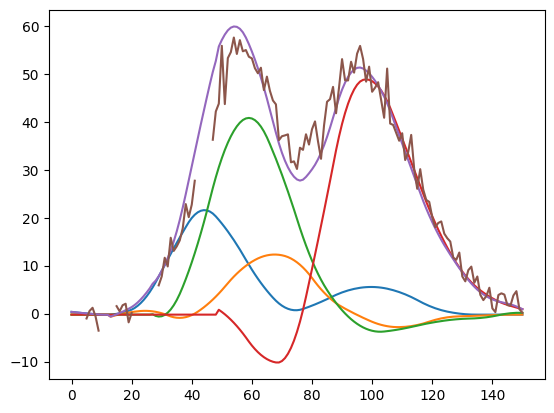

[ 0  2 10 22]


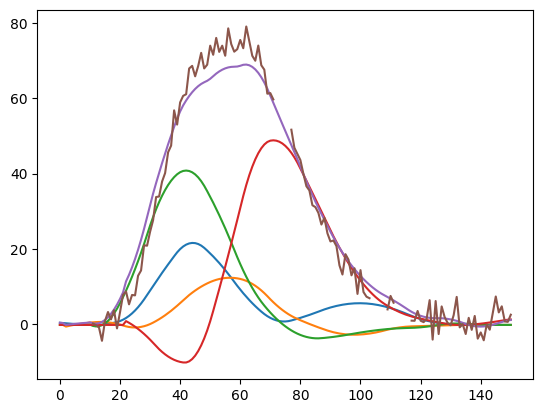

[ 0  2 19 65]


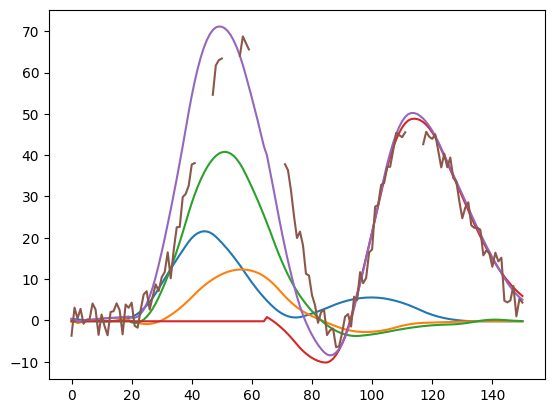

[ 0  7 11 54]


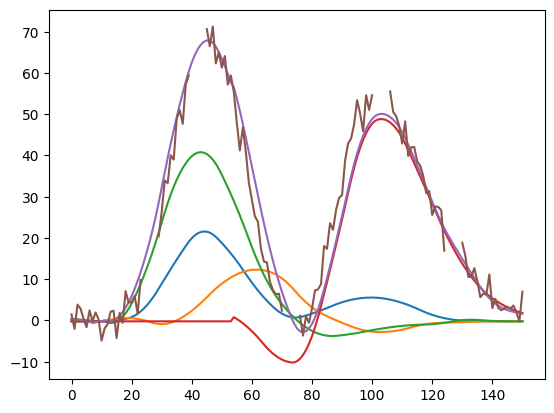

[ 0 31 39 59]


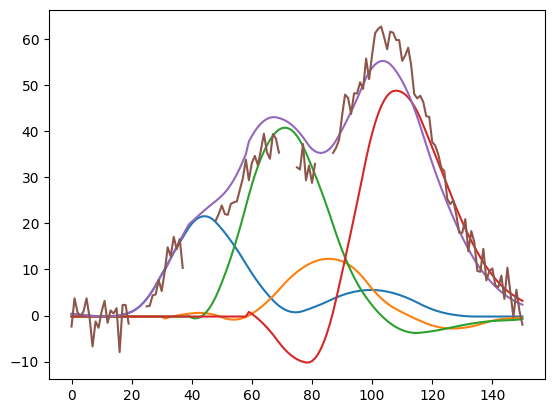

In [28]:
# Let's again visualize per series.
for s in range(5):
    pulse_loc_s = state_est[s]
    print(pulse_loc_s)
    mat_s = utils.create_event_matrix_time2(time[s],[s for _ in range(len(time[s]))],pulse_loc_s,identifiable=False,drop_outer_k=False, convolve=True, max_c=2500, nk=n_k, deg=2,n_s=n_s)
    y_s = np.ndarray.flatten(y_mat[s])
    ii = 1
    iii = 0
    for i in range(n_k,n_k*len(pulse_loc_s),n_k):
        plt.plot(mat_s[:,ii:i] @ coef_est2[ii:i] + coef_est2[0])
        iii += 1
        ii += n_k
    plt.plot(mat_s[:,ii:ii+n_k] @ coef_est2[ii:ii+n_k] + coef_est2[0])
    plt.plot(mat_s @ coef_est2) # Note how this one can shift up or down vertically.
    plt.plot(y_s)
    plt.show()

## Increasing complexity even more

In [29]:
# We have added random effects to the model, but our model still assumes the same sojourn time
# distributions for every series. Also, we still assume that events elicit the same response following the
# different events. Both assumptions might not be appropriate in cases where we have series from
# different conditions. The condition of each series would then be an ideal candidate to pass on
# as a covariate.

# Of course it is possible to simply fit separate models per condition as well. But you can in principle
# estimate all these variations in a single model. You would have to change the function used to create
# the model matrix (create_event_matrix_time2) in case you want the estimated shapes to differ per condition.
# What you would need to do is to embed the event_matrix block into an event_condition_matrix block.
# event_condition_matrix should be of dimension (rowsMat, ncol(event_matrix)*n_c) (n_c = number of conditions).
# event_matrix would then have to be embedded in the correct columns belonging to the condition of a series:
#
# event_condition_matrix[c*ncol(event_matrix):(c+1)*ncol(event_matrix)] = event_matrix
#
# If the series belongs to condition c=0, the first ncol(event_matrix) will be filled with event_matrix,
# every other cell in event_condition_matrix will be empty. This is similar to what is currently done by
# states j:
#
# cIndex = colsMat
# for ci in range(1,len(state_est)):
#    event_matrix[:,cIndex:cIndex+colsMat] = utils.B_spline_basis(ci,time,state_est, identifiable, drop_outer_k, convolve, min_c, max_c, nk, deg)
#    cIndex += colsMat
#
# Of course, you would also have to provide sufficiently more coefficients during initialization.

# If you also want the sojourn time distributions to differ per condition, then more changes are necessary:

# 1) We would have to adapt utils.m_gamma2s_sms_dc_gamm() to maximize gamma2 parameters per condition. Currently
# the function returns n_j - 1 scale parameters. A function that works per condition should return n_c (number
# of conditions) * (n_j - 1) scale parameters. Ideally, the first n_j - 1 belong to condition 1, the next to
# condition 2, and so on... 

# 2) We would also have to adapt the utils.ll_sms_dc_gamm() function to adjust the likelihood calculation to
# take into account the correct sojourn time distributions. The function receives data from every series
# separately - including the covariates for that series. So in case you have a covariate reflectin condition
# membership for a series, you should be able to get the unique condition for that series easily. If you
# implemented the utils.m_gamma2s_sms_dc_gamm() as suggested above, you could get the correct n_j - 1 gamma
# parameters by adjusting the following for-loop:
#
# for j in js:
#     alpha += ps[j].logpdf(state_dur_est[j,1])
#
# to instead index the sojourn time distributions (ps) as follows:
#
# ps[(c * (n_j - 1)) + j].logpdf(state_dur_est[j,1])
#
# If the series belongs to condition c=0, this will make sure the first n_j - 1 sojourn time distributions
# are selected. If the series belongs to condition 1 instead, this will select the next n_j - 1 distributions
# belonging to condition 1.

# 3) Model initializtion should then of course account for the additional scale parameters